In [49]:
import pandas as pd
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import mplfinance as mpf
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import sys
import pymysql as mysql
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense ,  LSTM, GRU, Dropout, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2251171236304862499
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11179585265058066721
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [9]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [10]:
page=1

# 삼성전자 005930
code='005930'
url='https://finance.naver.com/item/sise_day.nhn?code='+ code + '&page='

driver=webdriver.Chrome('c:/pydata/chromedriver.exe')
driver.get(url+str(page))
html = bs(driver.page_source, 'html.parser')
endPage=html.find('td', class_="pgRR").find('a')['href'].split('=')[-1]

nav_finance=[]

for page in range(1, int(endPage)+1):
    driver.get(url+str(page))
    html = bs(driver.page_source, 'html.parser')
    soup_tr=html.find_all('tr')
    for i in range(2, 15):
        day_data=[]
        soup_td=soup_tr[i].find_all('td')
        if len(soup_td) < 7 :
            continue
        else:
            for td_txt in soup_td:
                if td_txt.text == u'\xa0':
                    continue
                else:
                    day_data.append(td_txt.text.replace('.', '-').replace('\n','').replace('\t', '').replace(',', ''))
                    # day_data.append(re('[가-힣0-9a-zA-Z]+',td_txt.text))

        nav_finance.append(day_data)

driver.close()

df=pd.DataFrame(nav_finance, columns=['날짜','종가',"전일비",'시가','고가','저가','거래량'])
# print(df.info())
df=df.dropna()
# df['날짜']=pd.to_datetime(df['날짜'])
df['날짜'] = [ pd.to_datetime(df.iloc[date, 0]).strftime('%Y%m%d') for date in range(len(df))]
df = df.sort_values(by='날짜')

# 파일 저장 코드
#today = datetime.today().strftime('%Y_%m_%d')
# df.to_csv(f'./삼성전자_{today}.csv', index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8020\1258413710.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome('c:/pydata/chromedriver.exe')


In [11]:
df['날짜'] = [ int (pd.to_datetime(df.iloc[date, 0]).strftime('%Y%m%d')) for date in range(len(df))]
df

,날짜,종가,전일비,시가,고가,저가,거래량
6602,19960625,67500,0,66500,68300,65600,112960
6601,19960626,67700,200,67600,67900,66000,136630
6600,19960627,66900,800,67500,67700,66700,155450
6599,19960628,68100,1200,67300,68500,67200,138430
6598,19960629,68500,400,68100,69100,67100,96710
...,...,...,...,...,...,...,...
4,20221011,55400,800,54400,55700,54000,21437877
3,20221012,55800,400,55700,57000,55200,18408910
2,20221013,55200,600,55400,56100,55200,13784602
1,20221014,56300,1100,56200,56500,55800,12924326


In [12]:
df['날짜']

6602    19960625
6601    19960626
6600    19960627
6599    19960628
6598    19960629
          ...   
4       20221011
3       20221012
2       20221013
1       20221014
0       20221017
Name: 날짜, Length: 6603, dtype: int64

In [13]:
connect = mysql.connect(host='localhost', port=3306 ,db='test',
                        user='root', password='g901558', autocommit=True)
cursor = connect.cursor()
cnt = 0
cnt_not = 0
save_list = []
# 업데이트 되도록 개별로 커밋
sql = "insert into samsung values(%s, %s, %s, %s, %s, %s, %s)"
for i in tqdm(range(len(df))) :
    try :
        cursor.execute(sql, (df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2], df.iloc[i, 3], 
                        df.iloc[i, 4], df.iloc[i, 5], df.iloc[i, 6]))
        cnt += 1
        save_list.append(df.iloc[i, 0])
    except :
        cnt_not += 1
        pass
print('DB 저장완료')
print('신규 저장 데이터 : ', cnt, '기존 데이터 : ', cnt_not)
print('저장된 날짜 리스트 :', save_list)

  0%|          | 0/6603 [00:00<?, ?it/s]

DB 저장완료
신규 저장 데이터 :  3 기존 데이터 :  6600
저장된 날짜 리스트 : [20221013, 20221014, 20221017]


In [14]:
# 원하는 기간의 데이터 가져오기
month_want = 12 * 10
want_time = (datetime.today() - relativedelta(months=month_want)).strftime('%Y%m%d')

In [15]:
# 데이터 불러오기

sql = "SELECT * FROM samsung where 날짜>='" + want_time + "'"
cursor.execute(sql)
result = cursor.fetchall()
print(result)

(('20121017', '1336000', '6000', '1342000', '1346000', '1316000', '180461'), ('20121018', '1337000', '1000', '1336000', '1341000', '1328000', '210796'), ('20121019', '1302000', '35000', '1323000', '1325000', '1299000', '279959'), ('20121022', '1315000', '13000', '1277000', '1317000', '1276000', '234884'), ('20121023', '1313000', '2000', '1319000', '1322000', '1302000', '185296'), ('20121024', '1300000', '13000', '1297000', '1309000', '1289000', '269753'), ('20121025', '1322000', '22000', '1296000', '1322000', '1291000', '237942'), ('20121026', '1287000', '35000', '1306000', '1312000', '1287000', '276353'), ('20121029', '1299000', '12000', '1298000', '1299000', '1279000', '229431'), ('20121030', '1298000', '1000', '1299000', '1304000', '1292000', '133300'), ('20121031', '1310000', '12000', '1306000', '1312000', '1299000', '212428'), ('20121101', '1297000', '13000', '1295000', '1302000', '1290000', '209205'), ('20121102', '1327000', '30000', '1319000', '1333000', '1313000', '370592'), ('

In [16]:
df_db=pd.DataFrame(result, columns=['날짜','종가',"전일비",'시가','고가','저가','거래량'])
df_db

,날짜,종가,전일비,시가,고가,저가,거래량
0,20121017,1336000,6000,1342000,1346000,1316000,180461
1,20121018,1337000,1000,1336000,1341000,1328000,210796
2,20121019,1302000,35000,1323000,1325000,1299000,279959
3,20121022,1315000,13000,1277000,1317000,1276000,234884
4,20121023,1313000,2000,1319000,1322000,1302000,185296
...,...,...,...,...,...,...,...
2454,20221011,55400,800,54400,55700,54000,21437877
2455,20221012,56200,800,55700,57000,55200,8083620
2456,20221013,55200,600,55400,56100,55200,13784602
2457,20221014,56300,1100,56200,56500,55800,12924326


In [17]:
df_db.isnull().any()

날짜     False
종가     False
전일비    False
시가     False
고가     False
저가     False
거래량    False
dtype: bool

In [18]:
scaler = MinMaxScaler()
scale_cols = ['전일비','시가','고가','저가','거래량']
df_scaled = scaler.fit_transform(df_db[scale_cols])
df_db[scale_cols] = df_scaled
df_db['종가'] = df_db['종가'] .astype('int')
df_db

,날짜,종가,전일비,시가,고가,저가,거래량
0,20121017,1336000,0.042553,0.466783,0.468011,0.463707,0.001998
1,20121018,1337000,0.007092,0.464696,0.466273,0.467935,0.002334
2,20121019,1302000,0.248227,0.460174,0.460709,0.457717,0.003100
3,20121022,1315000,0.092199,0.444174,0.457928,0.449612,0.002601
4,20121023,1313000,0.014184,0.458783,0.459666,0.458774,0.002052
...,...,...,...,...,...,...,...
2454,20221011,55400,0.005674,0.018922,0.019367,0.019027,0.237391
2455,20221012,56200,0.005674,0.019374,0.019819,0.019450,0.089513
2456,20221013,55200,0.004255,0.019270,0.019506,0.019450,0.152643
2457,20221014,56300,0.007801,0.019548,0.019645,0.019662,0.143117


In [19]:
TEST_SIZE = 200
WINDOW_SIZE = 100
print('TEST_SIZE :', TEST_SIZE, 'WINDOW_SIZE :',WINDOW_SIZE)
train = df_db[:-TEST_SIZE]
test = df_db[-TEST_SIZE:]
test_date = df_db['날짜'][-TEST_SIZE:]

TEST_SIZE : 200 WINDOW_SIZE : 100


In [22]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [208]:
['종가','전일비','시가','고가','저가','거래량']

['종가', '전일비', '시가', '고가', '저가', '거래량']

In [20]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      2459 non-null   object 
 1   종가      2459 non-null   int32  
 2   전일비     2459 non-null   float64
 3   시가      2459 non-null   float64
 4   고가      2459 non-null   float64
 5   저가      2459 non-null   float64
 6   거래량     2459 non-null   float64
dtypes: float64(5), int32(1), object(1)
memory usage: 125.0+ KB


In [23]:
from sklearn.model_selection import train_test_split
import numpy as np
feature_cols = ['전일비','시가','고가','저가','거래량']
label_cols = ['종가']
train_feature = train[feature_cols]
train_label = train[label_cols]

X_train, y_train = make_dataset(train_feature, train_label, WINDOW_SIZE)

X_train.shape, y_train.shape

((2159, 100, 5), (2159, 1))

In [24]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 5), (200, 1))

In [25]:
test_feature, test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)
test_feature.shape, test_label.shape

((100, 100, 5), (100, 1))

In [26]:
train_feature.shape

(2259, 5)

In [27]:
model = Sequential([
     Dense(64, input_shape=(100, 5), activation='relu'),
     LSTM(128),
     Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 64)           384       
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99,329
Trainable params: 99,329
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile('adam', 'mean_squared_error')
model_path = 'best-samsung-stock-lstm.h5'
mc = ModelCheckpoint(model_path, monitor='val_loss',verbose=1, best_save_only = True)
es = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, 
                                    epochs=2000, 
                                    batch_size=16,
                                    validation_split = 0.2, 
                                    callbacks=[mc, es])

Epoch 1/2000
108/108 [==============================] - ETA: 0s - loss: 2079715753984.0000
Epoch 1: saving model to best-samsung-stock-lstm.h5
108/108 [==============================] - 13s 31ms/step - loss: 2079715753984.0000 - val_loss: 4982883840.0000
Epoch 2/2000
106/108 [============================>.] - ETA: 0s - loss: 2073701384192.0000
Epoch 2: saving model to best-samsung-stock-lstm.h5
108/108 [==============================] - 2s 23ms/step - loss: 2079675383808.0000 - val_loss: 4980854272.0000
Epoch 3/2000
107/108 [============================>.] - ETA: 0s - loss: 2082997141504.0000
Epoch 3: saving model to best-samsung-stock-lstm.h5
108/108 [==============================] - 2s 22ms/step - loss: 2079640780800.0000 - val_loss: 4978896384.0000
Epoch 4/2000
108/108 [==============================] - ETA: 0s - loss: 2079607226368.0000
Epoch 4: saving model to best-samsung-stock-lstm.h5
108/108 [==============================] - 3s 24ms/step - loss: 2079607226368.0000 - val_loss:

KeyboardInterrupt: 

In [29]:
best_model = load_model(model_path)
best_model.evaluate(test_feature, test_label)

4/4 [==============================] - 1s 17ms/step - loss: 2667044096.0000


2667044096.0

In [31]:
pred = best_model.predict(test_feature)
pred.shape

4/4 [==============================] - 0s 14ms/step


(100, 1)

In [33]:
pred.flatten().shape

(100,)

4/4 [==============================] - 0s 16ms/step


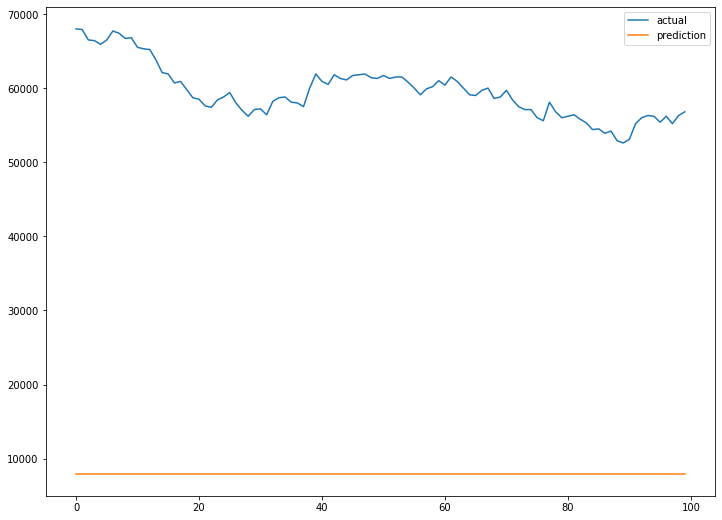

In [37]:
pred = best_model.predict(test_feature)
pred.reshape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred.flatten(), label = 'prediction')
plt.legend()
#plt.xticks(test_date)
plt.show()

In [107]:
from sklearn.model_selection import train_test_split
import numpy as np
feature_cols = ['전일비','시가', '거래량']
label_cols = ['종가']
X_train = train[feature_cols].values
y_train = train[label_cols].values

In [108]:
X_test = test[feature_cols].values
y_test = test[label_cols].values

X_test.shape, test_label.shape

((200, 3), (100, 1))

In [109]:
model = Sequential([
     Embedding(3, 64),
     LSTM(128,  return_sequences=True, activation='relu'),
     GRU(256, activation='relu'),
     Dense(64, activation='relu'),
     Dense(1)])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          192       
                                                                 
 lstm_8 (LSTM)               (None, None, 128)         98816     
                                                                 
 gru_10 (GRU)                (None, 256)               296448    
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 411,969
Trainable params: 411,969
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile('adam', 'mean_squared_error')
model_path = 'best-samsung-stock-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, best_save_only = True)
es = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, 
                                    epochs=2000, 
                                    batch_size=16,
                                    validation_split = 0.2, 
                                    callbacks=[mc, es])

Epoch 1/2000
113/113 [==============================] - ETA: 0s - loss: 1819321565184.0000
Epoch 1: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 9s 41ms/step - loss: 1819321565184.0000 - val_loss: 2116897341440.0000
Epoch 2/2000
113/113 [==============================] - ETA: 0s - loss: 627089539072.0000
Epoch 2: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 4s 37ms/step - loss: 627089539072.0000 - val_loss: 1455943581696.0000
Epoch 3/2000
113/113 [==============================] - ETA: 0s - loss: 614143361024.0000
Epoch 3: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 4s 36ms/step - loss: 614143361024.0000 - val_loss: 1336594661376.0000
Epoch 4/2000
113/113 [==============================] - ETA: 0s - loss: 621303169024.0000
Epoch 4: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 4s 35ms/step - loss: 621303169024.0000 - val_los

In [99]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 11ms/step - loss: 1111197614080.0000


1111197614080.0

In [105]:
best_model.predict(X_test[0].reshape(-1, 5))

1/1 [==============================] - 0s 32ms/step


array([[1119742.8]], dtype=float32)

In [106]:
y_test[0]

array([79400])

In [ ]:
X_test.iloc[0, :].values.reshape(-1,5)

array([[0.00921986, 0.02744348, 0.02760779, 0.02776603, 0.18942106]])

7/7 [==============================] - 1s 10ms/step


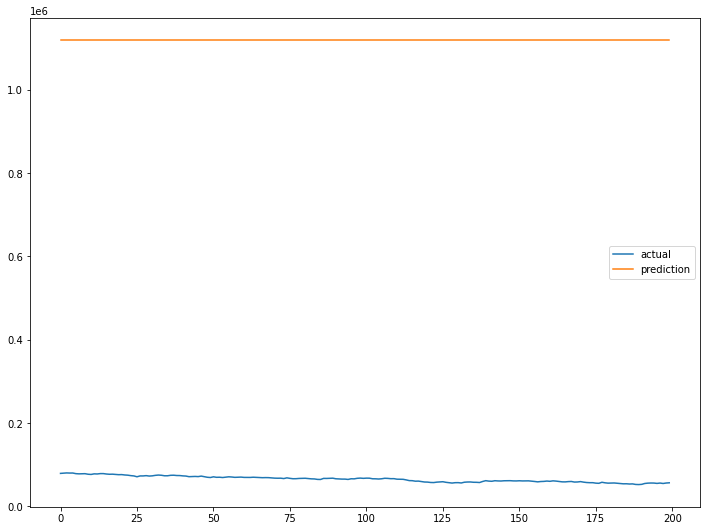

In [102]:
pred = best_model.predict(X_test)
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred.flatten(), label = 'prediction')
plt.legend()
#plt.xticks(test_date)
plt.show()

## 년/월/일/거래량/시가/종가 기준으로 값 입력

In [115]:
df_db.head()

,날짜,종가,전일비,시가,고가,저가,거래량
0,20121017,1336000,0.042553,0.466783,0.468011,0.463707,0.001998
1,20121018,1337000,0.007092,0.464696,0.466273,0.467935,0.002334
2,20121019,1302000,0.248227,0.460174,0.460709,0.457717,0.003100
3,20121022,1315000,0.092199,0.444174,0.457928,0.449612,0.002601
4,20121023,1313000,0.014184,0.458783,0.459666,0.458774,0.002052


In [114]:
df_db_test = df_db[['시가', '거래량']]
df_db_test['년'] = str(df_db['날짜'])[]

,시가,거래량
0,0.466783,0.001998
1,0.464696,0.002334
2,0.460174,0.003100
3,0.444174,0.002601
4,0.458783,0.002052
...,...,...
2454,0.018922,0.237391
2455,0.019374,0.089513
2456,0.019270,0.152643
2457,0.019548,0.143117


In [136]:
df_year = []
df_month = []
df_day = []
for idx in df_db.index:
    df_year.append(int(str(df_db.loc[idx, '날짜'])[:4]))
for idx in df_db.index:
    df_month.append(int(str(df_db.loc[idx, '날짜'])[4:6]))
for idx in df_db.index:
    df_day.append(int(str(df_db.loc[idx, '날짜'])[6:])) 
df_db_test['년'] = df_year
df_db_test['월'] = df_month
df_db_test['일'] = df_day

C:\Users\Admin\AppData\Local\Temp\ipykernel_8020\1094306769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_db_test['년'] = df_year
C:\Users\Admin\AppData\Local\Temp\ipykernel_8020\1094306769.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_db_test['월'] = df_month
C:\Users\Admin\AppData\Local\Temp\ipykernel_8020\1094306769.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [137]:
df_db_test.head()

,시가,거래량,년,월,일
0,0.466783,0.001998,2012,10,17
1,0.464696,0.002334,2012,10,18
2,0.460174,0.003100,2012,10,19
3,0.444174,0.002601,2012,10,22
4,0.458783,0.002052,2012,10,23


In [138]:
X_train = df_db_test[:-TEST_SIZE].values
X_test = df_db_test[-TEST_SIZE:].values
y_train = df_db['종가'][:-TEST_SIZE].values
y_test = df_db['종가'][-TEST_SIZE:].values
test_date = df_db['날짜'][-TEST_SIZE:].values

In [139]:
X_train

array([[4.66782609e-01, 1.99832399e-03, 2.01200000e+03, 1.00000000e+01,
        1.70000000e+01],
       [4.64695652e-01, 2.33423678e-03, 2.01200000e+03, 1.00000000e+01,
        1.80000000e+01],
       [4.60173913e-01, 3.10010909e-03, 2.01200000e+03, 1.00000000e+01,
        1.90000000e+01],
       ...,
       [2.67130435e-02, 1.45155951e-01, 2.02100000e+03, 1.20000000e+01,
        1.70000000e+01],
       [2.69913043e-02, 1.24735377e-01, 2.02100000e+03, 1.20000000e+01,
        2.00000000e+01],
       [2.70956522e-02, 1.57744448e-01, 2.02100000e+03, 1.20000000e+01,
        2.10000000e+01]])

In [150]:
del model

In [151]:
model = Sequential([
     Embedding(5, 64),
     LSTM(128,  return_sequences=True, activation='relu'),
     GRU(256, activation='relu'),
     Dropout(0.25),
     Dense(64, activation='relu'),
     Dropout(0.5),
     Dense(1)])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          320       
                                                                 
 lstm_12 (LSTM)              (None, None, 128)         98816     
                                                                 
 gru_14 (GRU)                (None, 256)               296448    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)               

In [152]:
model.compile('adam', 'mean_squared_error')
model_path = 'best-samsung-stock-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, best_save_only = True)
es = EarlyStopping(patience=20)
history = model.fit(X_train, y_train, 
                                    epochs=2000, 
                                    batch_size=16,
                                    validation_split = 0.2, 
                                    callbacks=[mc, es])

Epoch 1/2000
113/113 [==============================] - ETA: 0s - loss: 1433234964480.0000
Epoch 1: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 12s 60ms/step - loss: 1433234964480.0000 - val_loss: 1415513505792.0000
Epoch 2/2000
113/113 [==============================] - ETA: 0s - loss: 693060304896.0000
Epoch 2: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 6s 57ms/step - loss: 693060304896.0000 - val_loss: 1308308144128.0000
Epoch 3/2000
113/113 [==============================] - ETA: 0s - loss: 686904705024.0000
Epoch 3: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 9s 76ms/step - loss: 686904705024.0000 - val_loss: 915206832128.0000
Epoch 4/2000
113/113 [==============================] - ETA: 0s - loss: 681546612736.0000
Epoch 4: saving model to best-samsung-stock-lstm.h5
113/113 [==============================] - 8s 73ms/step - loss: 681546612736.0000 - val_los

In [153]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 21ms/step - loss: 1070485209088.0000


1070485209088.0

7/7 [==============================] - 1s 12ms/step


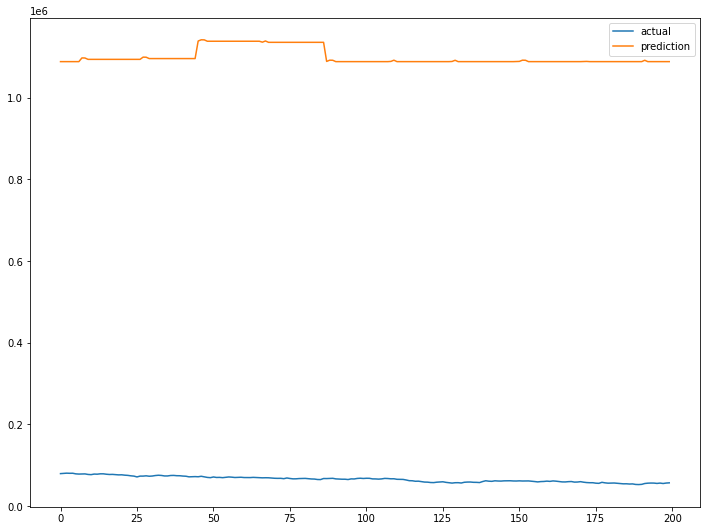

In [155]:
pred = best_model.predict(X_test)
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred.flatten(), label = 'prediction')
plt.legend()
# plt.xticks(list(test_date))
plt.show()

In [161]:
X_train.shape

(2259, 5)

In [167]:
model2 = Sequential([
     Embedding(5, 32),
     GRU(128),
     Dense(1)])
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 32)          160       
                                                                 
 gru_18 (GRU)                (None, 128)               62208     
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 62,497
Trainable params: 62,497
Non-trainable params: 0
_________________________________________________________________


In [168]:
model2.compile('adam', 'mean_squared_error')
model_path2 = 'best-samsung-stock-gru.h5'
mc = ModelCheckpoint(model_path2, verbose=1, best_save_only = True)
es = EarlyStopping(patience=20)
history = model2.fit(X_train, y_train, 
                                    epochs=2000, 
                                    batch_size=16,
                                    validation_split = 0.2, 
                                    callbacks=[mc, es])

Epoch 1/2000
112/113 [============================>.] - ETA: 0s - loss: 2103602184192.0000
Epoch 1: saving model to best-samsung-stock-gru.h5
113/113 [==============================] - 4s 15ms/step - loss: 2103209492480.0000 - val_loss: 4880114688.0000
Epoch 2/2000
109/113 [===========================>..] - ETA: 0s - loss: 2089586524160.0000
Epoch 2: saving model to best-samsung-stock-gru.h5
113/113 [==============================] - 1s 12ms/step - loss: 2103159554048.0000 - val_loss: 4877934592.0000
Epoch 3/2000
108/113 [===========================>..] - ETA: 0s - loss: 2081090568192.0000
Epoch 3: saving model to best-samsung-stock-gru.h5
113/113 [==============================] - 1s 13ms/step - loss: 2103121281024.0000 - val_loss: 4875855360.0000
Epoch 4/2000
111/113 [============================>.] - ETA: 0s - loss: 2093753171968.0000
Epoch 4: saving model to best-samsung-stock-gru.h5
113/113 [==============================] - 1s 11ms/step - loss: 2103084843008.0000 - val_loss: 4873

KeyboardInterrupt: 

In [169]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 14ms/step - loss: 1070485209088.0000


1070485209088.0

7/7 [==============================] - 1s 14ms/step


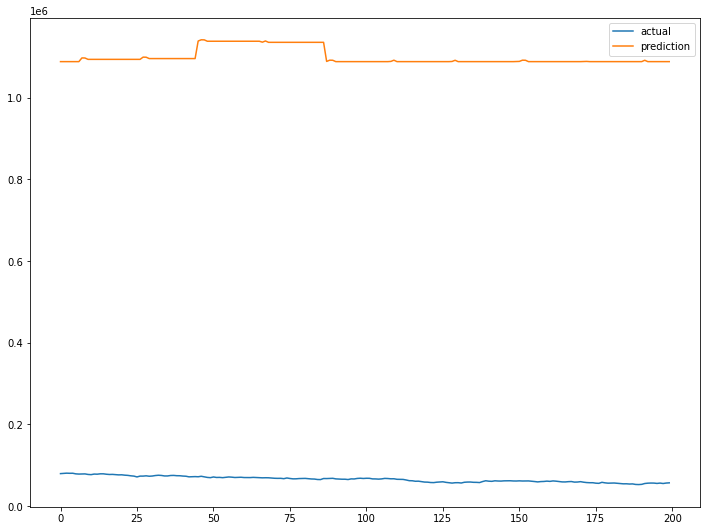

In [170]:
pred = best_model.predict(X_test)
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred.flatten(), label = 'prediction')
plt.legend()
# plt.xticks(list(test_date))
plt.show()